In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import nengo
import nengo_dl
%load_ext nengo.ipynb
from nengo.spa import Vocabulary

# Change the seed of this RNG to change the vocabulary
import random
import string
import sys
from io import StringIO
import pickle
import tensorflow as tf

LOADING = False

/home/clvcooke/nengo_deep/lib/python3.4/site-packages/nengo_dl/__init__.py:18: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  warnings.warn("No GPU support detected. It is recommended that you "


<IPython.core.display.Javascript object>

In [2]:
def gen_pointers(amount, vocabulary):
    pairs = []
    for v in range(amount):
        # generate amount pairs
        # keys start with A, second element starts with B, third starts with C
        conv_key = 'C' + str(v)
        point_key_1= 'A' + str(v)
        pointer_1 = vocabulary.create_pointer(attempts=500)
        point_key_2 = 'B' + str(v)
        pointer_2 = vocabulary.create_pointer(attempts=500)
        vocabulary.add(point_key_1, pointer_1)
        vocabulary.add(point_key_2, pointer_2)
        vocabulary.add(conv_key, vocabulary.parse(point_key_2 + "*" + point_key_1))

In [3]:
def repeat_pointer(pointer, steps):
    return np.repeat(np.expand_dims(pointer, axis=0), steps, axis=0)

def generate_data(dims, seed, amount, steps):
    state = np.random.RandomState(seed)
    vocabulary = Vocabulary(dimensions=dims, rng=state)
    gen_pointers(amount, vocabulary)
    A = np.asarray([repeat_pointer(vocabulary['A' + str(i)].v,steps) for i in range(amount)])
    B = np.asarray([repeat_pointer(vocabulary['B' + str(i)].v,n_steps) for i in range(amount)])
    C = np.asarray([repeat_pointer(vocabulary['C' + str(i)].v,n_steps) for i in range(amount)])
    return A, B, C, vocabulary

In [4]:
# Number of dimensions for the Semantic Pointers
dimensions = 50
n_steps = 300
minibatch_size = 5

if LOADING:
    vocab = pickle.load(open('vocab2.p', 'rb'))
else:
    test_a, test_b, test_c, vocab = generate_data(dimensions, 0, minibatch_size, n_steps)
    pickle.dump(vocab, open('vocab2.p', 'wb'))

In [5]:
model = nengo.Network()
with model:
    model.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear()
    model.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    model.config[nengo.Ensemble].bias = nengo.dists.Uniform(-1, 1)
#     model.config[nengo.Connection].synapse = None
    # Get the raw vectors for the pointers using `vocab['A'].v`
    a = nengo.Node(output=vocab['A0'].v)
    b = nengo.Node(output=vocab['B0'].v)

    # Make the circular convolution network with 200 neurons
    cconv = nengo.networks.CircularConvolution(400, dimensions=dimensions)

    # Connect the input nodes to the input slots `A` and `B` on the network
    nengo.Connection(a, cconv.input_a)
    nengo.Connection(b, cconv.input_b)

    # Probe the output
    out = nengo.Probe(cconv.output, synapse=0.03)

In [6]:
with nengo.Simulator(model) as sim:
    sim.run(0.3)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


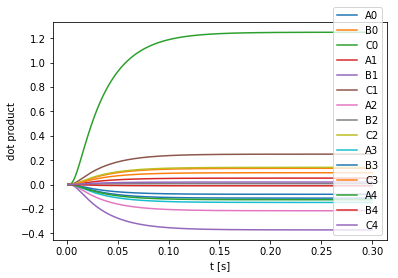

In [ ]:
plt.figure()
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[out], vocab))
plt.legend(vocab.keys, loc=4)
plt.xlabel("t [s]")
plt.ylabel("dot product");

In [27]:
def objective_cosine(outputs, targets):
    return tf.abs(tf.losses.cosine_distance(targets, outputs, dim=2))
    
with nengo_dl.Simulator(model, step_blocks=n_steps, minibatch_size=minibatch_size, device="/cpu:0") as sim:
    test_input_feed = {a:test_a,
                       b:test_b}
    test_output_feed = {out: test_c}    
    optimizer = tf.train.RMSPropOptimizer(1e-3, decay=0.9, momentum=0.0, epsilon=1e-10, use_locking=False, centered=False, name='RMSProp')
    print("LOSS: " + str(sim.loss(test_input_feed, test_output_feed, objective_cosine)))
    for e in range(50):
        train_a, train_b, train_c, _ = generate_data(dimensions, e+1, minibatch_size, n_steps)
        input_feed = {a:train_a, 
                      b: train_b}
        output_feed = {out: train_c}
        sim.train(input_feed, output_feed, optimizer, n_epochs=1, objective=objective_cosine)
        print("LOSS: " + str(sim.loss(test_input_feed, test_output_feed, objective_cosine)))
    sim.save_params('circular_convolution2')
    sim.run(0.3)

Building completed in 0:00:05 
Optimization completed in 0:00:00 
Construction completed in 0:00:00 
LOSS: 0.126335442066
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:35
LOSS: 0.131766811013
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:34
LOSS: 0.126895844936
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:34
LOSS: 0.122006550431
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:34
LOSS: 0.117637529969
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:34
LOSS: 0.112898923457
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:34
LOSS: 0.108471535146
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:34
LOSS: 0.10369887203
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:34
LOSS: 0.0992260351777
[#############

In [30]:
output = sim.data[out]

In [31]:
with nengo_dl.Simulator(model) as sim:
    sim.load_params('circular_convolution2')
    sim.run(0.3)
    print(sim.loss(test_input_feed, test_output_feed, objective_cosine))

Building completed in 0:00:05 
Optimization completed in 0:00:00 
Construction completed in 0:00:00 
INFO:tensorflow:Restoring parameters from circular_convolution2
Simulation completed in 0:00:02
2.06548779011


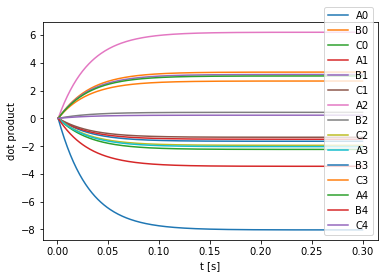

In [33]:
plt.figure()
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[out], vocab))
plt.legend(vocab.keys, loc=4)
plt.xlabel("t [s]")
plt.ylabel("dot product");

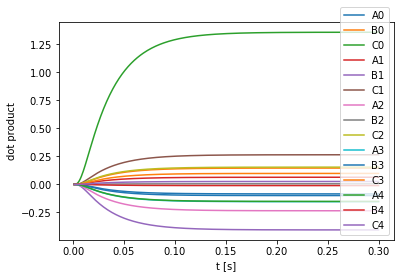

In [34]:
plt.figure()
plt.plot(sim.trange(), nengo.spa.similarity(output[0], vocab))
plt.legend(vocab.keys, loc=4)
plt.xlabel("t [s]")
plt.ylabel("dot product");